# Video game Logistic Regression - resample - EU from NA and JP
This notebook uses a Logistic Regression ML model to predict EU Sales based on Platform, Genre, NA_Sales, and JP_Sales. The notebook sets the threshold for EU_Sales to some value independent of the median value of EU_Sales and investigates oversampling, undersampling, and combination sampling to balance the yes/no values for EU_Sales. 

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Read in data and remove unnecessary columns

In [2]:
# Import data
path = "resources/vgsales.csv"
vg_sales_df = pd.read_csv(path)
vg_sales_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
# vg_sales_df[vg_sales_df["Global_Sales"] < 0.13].count()

In [4]:
# Drop columns
vg_sales_df.drop(["Name", "Year", "Publisher", "Other_Sales", "Global_Sales"], axis=1, inplace=True)
vg_sales_df.set_index("Rank", inplace=True)
vg_sales_df.head()

,Platform,Genre,NA_Sales,EU_Sales,JP_Sales
Rank,,,,,
1,Wii,Sports,41.49,29.02,3.77
2,NES,Platform,29.08,3.58,6.81
3,Wii,Racing,15.85,12.88,3.79
4,Wii,Sports,15.75,11.01,3.28
5,GB,Role-Playing,11.27,8.89,10.22


In [5]:
n = 6798
vg_sales_df.drop(vg_sales_df.tail(n).index, inplace=True)
vg_sales_df.count()

Platform    9800
Genre       9800
NA_Sales    9800
EU_Sales    9800
JP_Sales    9800
dtype: int64

In [6]:
# Get unique Platform values
vg_sales_df["Platform"].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16'],
      dtype=object)

In [7]:
# Make sure there are no null values
vg_sales_df["Platform"].isnull().sum()

0

In [8]:
# Get unique Genre values
vg_sales_df["Genre"].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [9]:
# Make sure there are no null values
vg_sales_df["Genre"].isnull().sum()

0

In [10]:
# Make sure sales columns do not have null values
print(f"NA_Sales has {vg_sales_df['NA_Sales'].isnull().sum()} null values.")
print(f"EU_Sales has {vg_sales_df['EU_Sales'].isnull().sum()} null values.")
print(f"JP_Sales has {vg_sales_df['JP_Sales'].isnull().sum()} null values.")

NA_Sales has 0 null values.
EU_Sales has 0 null values.
JP_Sales has 0 null values.


In [11]:
# Write reduced df to csv
# vg_sales_df.to_csv('resources/vgsales_reduced_NA_and_EU.csv')

## Histogram of Sales Data

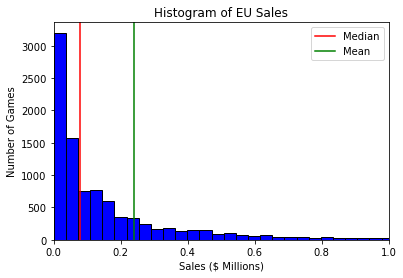

The median sales for EU is $0.08 Million


In [12]:
# Create Histogram to view NA Sales distribution
plt.hist(vg_sales_df['EU_Sales'], color = 'blue', edgecolor = 'black',
         bins = 800)
plt.title('Histogram of EU Sales')
plt.xlabel('Sales ($ Millions)')
plt.ylabel('Number of Games')
plt.xlim(left=0, right=1)
plt.axvline(vg_sales_df['EU_Sales'].median(),label="Median",color='red')
plt.axvline(vg_sales_df['EU_Sales'].mean(),label="Mean",color='green')
plt.legend()
plt.show()

print(f"The median sales for EU is ${round(vg_sales_df['EU_Sales'].median(),3)} Million")

## Categorize Other_Sales Column

In [13]:
# Copy vg_sales_df
categorize_eu_sales = vg_sales_df.filter(["EU_Sales"], axis=1)
categorize_eu_sales

,EU_Sales
Rank,
1,29.02
2,3.58
3,12.88
4,11.01
5,8.89
...,...
9797,0.00
9798,0.00
9799,0.00


## Calculate statistics for EU Sales

In [14]:
eu_sales_stats = vg_sales_df.filter(["EU_Sales"], axis=1)
# eu_sales_stats.quantile(q=0.75)

## Set Threshold Sales Number

In [15]:
# Set threshold sales number
# na_sales_threshold = round(sales_data_nrm['NA_Sales'].median(),3)
# eu_sales_threshold = 0.2
# eu_sales_threshold = eu_sales_stats.quantile(q=0.75)[0]
eu_sales_threshold = vg_sales_df.filter(["EU_Sales"], axis=1).quantile(q=0.75)[0]
eu_sales_threshold

0.22

In [16]:
eu_sales_stats.describe()

,EU_Sales
count,9800.000000
mean,0.241077
std,0.640782
min,0.000000
25%,0.020000
50%,0.080000
75%,0.220000
max,29.020000


In [17]:
# Reassign NA_sales value
for index,row in categorize_eu_sales.iterrows():
    
    # NA Sales
    if row.EU_Sales > eu_sales_threshold:
        categorize_eu_sales.loc[index] = 1
    else:
        categorize_eu_sales.loc[index] = 0

eu_sales_col_name = "EU_Sales_gt_" + str(eu_sales_threshold)
categorize_eu_sales.\
    rename(columns={"EU_Sales": eu_sales_col_name}, inplace=True)

categorize_eu_sales.head()

,EU_Sales_gt_0.22
Rank,
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0


In [18]:
# Write categorized df to csv file
# output_file_str = "EU_Sales_nrm_thresh_" + \
#     str(eu_sales_threshold).split(".")[0] + "p" + str(eu_sales_threshold).split(".")[1] + ".csv"
# categorize_eu_sales.to_csv('resources/' + output_file_str)

## Separate Sales Data for NA and JP

In [19]:
sales_data = vg_sales_df.filter(["NA_Sales", "JP_Sales"], axis=1)
sales_data.head()

,NA_Sales,JP_Sales
Rank,,
1,41.49,3.77
2,29.08,6.81
3,15.85,3.79
4,15.75,3.28
5,11.27,10.22


In [20]:
# Create platform df
platform_df = vg_sales_df.filter(["Platform"], axis=1)
platform_df.head()

,Platform
Rank,
1,Wii
2,NES
3,Wii
4,Wii
5,GB


## Encode Platform data

In [21]:
# Encode platform df
platform_encoded_df = pd.get_dummies(platform_df)
platform_encoded_df.head()

,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_N64,Platform_NES,...,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne
Rank,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Get shape of platform_encoded_df
platform_encoded_df.shape

(9800, 28)

In [23]:
# Write encoded platform data to CSV
# platform_encoded_df.to_csv('resources/encoded_platform.csv')

## Encode Genre data

In [24]:
# Create genre df
genre_df = vg_sales_df.filter(["Genre"], axis=1)
genre_df.head()

,Genre
Rank,
1,Sports
2,Platform
3,Racing
4,Sports
5,Role-Playing


In [25]:
# Encode genre df
genre_encoded_df = pd.get_dummies(genre_df)
genre_encoded_df.head()

,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,1,0,0,0,0


In [26]:
# Get shape of genre_encoded_df
genre_encoded_df.shape

(9800, 12)

In [27]:
# Write encoded genre data to CSV
# genre_encoded_df.to_csv('resources/encoded_genre.csv')

## Combine dataframes for analysis

In [28]:
# Combine dataframes to create sales_df_encoded
sales_df_encoded = categorize_eu_sales.join(sales_data, how='outer').\
    join(platform_encoded_df, how='outer').join(genre_encoded_df, how='outer')
sales_df_encoded.head()

,EU_Sales_gt_0.22,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,,,,,,,,,,
1,1.0,41.49,3.77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,29.08,6.81,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1.0,15.85,3.79,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.0,15.75,3.28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1.0,11.27,10.22,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
# Create smaller df of 100 rows selected randomly from larger dataset
sales_reduced = sales_df_encoded.sample(n=9800)
sales_reduced.head()

,EU_Sales_gt_0.22,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,,,,,,,,,,
634,1.0,0.87,0.00,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6844,0.0,0.00,0.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2651,1.0,0.24,0.01,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5390,0.0,0.22,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9480,0.0,0.07,0.05,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [30]:
# Drop the index
sales_reduced_no_idx = sales_reduced.reset_index(drop=True)
sales_reduced_no_idx.head()

,EU_Sales_gt_0.22,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,1.0,0.87,0.00,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,0.00,0.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,0.24,0.01,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,0.22,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,0.07,0.05,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Perform ML with Logistic Regression

In [31]:
# Count True/False NA_Sales numbers
sales_reduced_no_idx[eu_sales_col_name].value_counts()

0.0    7352
1.0    2448
Name: EU_Sales_gt_0.22, dtype: int64

In [32]:
# Set X and y data
y = sales_reduced_no_idx[eu_sales_col_name]
X = sales_reduced_no_idx.drop(columns=eu_sales_col_name)

In [33]:
# Split data into training and testing data
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
# X_train.shape
Counter(y_train)

Counter({0.0: 5514, 1.0: 1836})

### Oversample data

Random Oversampling

In [34]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({0.0: 5514, 1.0: 5514})

In [35]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [36]:
# Train the model
classifier.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=200, random_state=1)

In [37]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,1.0,0.0
6,1.0,1.0
7,0.0,0.0
8,1.0,0.0
9,1.0,1.0


In [38]:
# Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8383673469387755


In [39]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8116203318469208

In [40]:
# # Print confusion matrix
# from sklearn.metrics import confusion_matrix, classification_report
# matrix = confusion_matrix(y_test, y_pred)
# print(matrix)

# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1590,248
Actual > threshold,148,464


In [41]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      1838
         1.0       0.65      0.76      0.70       612

    accuracy                           0.84      2450
   macro avg       0.78      0.81      0.80      2450
weighted avg       0.85      0.84      0.84      2450



In [42]:
print('Train Score: ', round(classifier.score(X_resampled, y_resampled)*100,1))
print('Test Score: ', round(classifier.score(X_test, y_test)*100,1))

Train Score:  82.3
Test Score:  83.8


In [43]:
# Look at feature importance
coefficients = classifier.coef_[0].tolist()
coefficients[:5]

[4.376418114200422,
 0.39469225183932544,
 -5.444412091790272,
 1.1306313387960978,
 -0.072219178370717]

In [44]:
len(coefficients)

42

In [45]:
len(X.columns)

42

In [46]:
feature_coefficients = pd.DataFrame({
    "Feature":X.columns,
    "Coefficient":coefficients
})
feature_coefficients.head()

,Feature,Coefficient
0,NA_Sales,4.376418
1,JP_Sales,0.394692
2,Platform_2600,-5.444412
3,Platform_3DS,1.130631
4,Platform_DC,-0.072219


In [47]:
feature_coefficients_sorted = feature_coefficients.iloc[feature_coefficients['Coefficient'].abs().argsort()]\
    [::-1][:len(feature_coefficients)].reset_index(drop=True)
feature_coefficients_sorted.head(10)

,Feature,Coefficient
0,Platform_2600,-5.444412
1,NA_Sales,4.376418
2,Platform_PC,2.677195
3,Platform_PS4,2.075362
4,Platform_NES,-1.744381
5,Platform_PS3,1.553264
6,Platform_SAT,-1.503453
7,Platform_GC,-1.496723
8,Platform_SNES,-1.466595
9,Platform_3DS,1.130631


In [48]:
# Find the intercept
intercept = classifier.intercept_[0]
intercept

-2.417208929214597

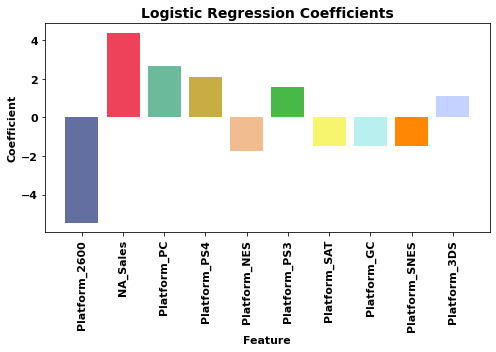

In [49]:
feature_coefficients_sorted_for_plot = feature_coefficients_sorted.head(10)

import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
cmap = matplotlib.cm.get_cmap('cubehelix')
colors = cmap(np.arange(cmap.N))

colors = ['#636FA0','#EE415A','#6ABA9B','#C8AD45','#F2BC91','#48B949',
         '#F7F56D','#B9F0EF','#FF8704','#C5D2FF']

# feature_coefficients_sorted_for_plot.plot.bar(x="Feature", y="Coefficient")
plt.bar(feature_coefficients_sorted_for_plot["Feature"],
        feature_coefficients_sorted_for_plot["Coefficient"],
        color=colors)
plt.xticks(rotation=90, size=11, weight="bold")
plt.yticks(size=11, weight="bold")
plt.title("Logistic Regression Coefficients", size=14, weight="bold")
plt.ylabel("Coefficient", size=11, weight="bold")
plt.xlabel("Feature", size=11, weight="bold")
fig = plt.gcf()
fig.set_size_inches([7,5])
plt.tight_layout()
# plt.savefig('LR_Coefficients_no_bkgnd.png', transparent=True)
plt.show()



Investigate LR Probabilities

In [50]:
probs_test = classifier.predict_proba(X_test)
probs_test

array([[0.65165855, 0.34834145],
       [0.84257507, 0.15742493],
       [0.96192014, 0.03807986],
       ...,
       [0.38388224, 0.61611776],
       [0.80351355, 0.19648645],
       [0.86889273, 0.13110727]])

In [51]:
len(probs_test)

2450

In [52]:
probs_0 = classifier.predict_proba(X_test)[:,0]
probs_0

array([0.65165855, 0.84257507, 0.96192014, ..., 0.38388224, 0.80351355,
       0.86889273])

In [53]:
probs_1 = classifier.predict_proba(X_test)[:,1]
probs_1

array([0.34834145, 0.15742493, 0.03807986, ..., 0.61611776, 0.19648645,
       0.13110727])

In [54]:
# Create dataframe with predictions and probabilities
pred_df = pd.DataFrame({
    "Validation":y_test,
    "Prediction":y_pred,
    "0_Probability":probs_0,
    "1_Probability":probs_1
})
pred_df

,Validation,Prediction,0_Probability,1_Probability
7342,0.0,0.0,0.651659,0.348341
8500,0.0,0.0,0.842575,0.157425
8021,0.0,0.0,0.961920,0.038080
553,0.0,0.0,0.859276,0.140724
9432,0.0,0.0,0.939850,0.060150
...,...,...,...,...
4150,0.0,0.0,0.795554,0.204446
4591,0.0,0.0,0.828206,0.171794
3613,1.0,1.0,0.383882,0.616118
1465,0.0,0.0,0.803514,0.196486


In [55]:
# Create dataframe for 0 class, then create histograms to display probabilities
probs_0_df = pred_df.loc[pred_df["Prediction"] == 0]
probs_0_df.head()

,Validation,Prediction,0_Probability,1_Probability
7342,0.0,0.0,0.651659,0.348341
8500,0.0,0.0,0.842575,0.157425
8021,0.0,0.0,0.961920,0.038080
553,0.0,0.0,0.859276,0.140724
9432,0.0,0.0,0.939850,0.060150


In [56]:
# Create dataframe for 1 class, then create histograms to display probabilities
probs_1_df = pred_df.loc[pred_df["Prediction"] == 1]
probs_1_df.head(10)

,Validation,Prediction,0_Probability,1_Probability
7261,0.0,1.0,0.381606,0.618394
6334,1.0,1.0,0.005602,0.994398
6215,0.0,1.0,0.378799,0.621201
8693,1.0,1.0,0.018487,0.981513
2089,1.0,1.0,0.086065,0.913935
1858,0.0,1.0,0.499144,0.500856
5537,1.0,1.0,0.436324,0.563676
2886,1.0,1.0,0.002228,0.997772
2798,0.0,1.0,0.392382,0.607618
4352,1.0,1.0,0.074537,0.925463


Create plots for probabilities

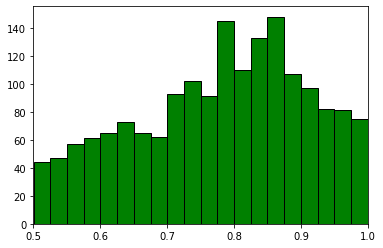

In [57]:
plt.hist(probs_0_df["0_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
# plt.savefig('LR_0_probability_hist.png')
plt.show()

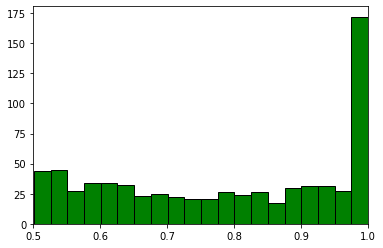

In [58]:
plt.hist(probs_1_df["1_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
# plt.savefig('LR_1_probability_hist.png')
plt.show()

Plot Decision Boundary

In [59]:
test_combined_df = X_test.copy()
test_combined_df.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
7342,0.28,0.23,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8500,0.00,0.14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8021,0.10,0.00,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
553,0.21,0.00,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
9432,0.15,2.05,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [60]:
test_combined_df["Y_pred"] = y_pred
test_combined_df.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,...,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Y_pred
7342,0.28,0.23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
8500,0.00,0.14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
8021,0.10,0.00,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0.0
553,0.21,0.00,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.0
9432,0.15,2.05,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0


In [61]:
test_combined_pred_0 = test_combined_df.loc[test_combined_df["Y_pred"] == 0]
test_combined_pred_0.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,...,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Y_pred
7342,0.28,0.23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
8500,0.00,0.14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
8021,0.10,0.00,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0.0
553,0.21,0.00,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.0
9432,0.15,2.05,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0


In [62]:
test_combined_pred_1 = test_combined_df.loc[test_combined_df["Y_pred"] == 1]
test_combined_pred_1.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,...,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Y_pred
7261,0.69,0.49,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.0
6334,1.30,0.27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
6215,0.04,0.00,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.0
8693,1.36,0.04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2089,0.67,0.12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0


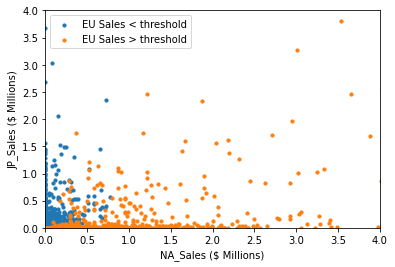

In [63]:
# Create scatter plot
plt.scatter(test_combined_pred_0["NA_Sales"], test_combined_pred_0["JP_Sales"], s=10, label='EU Sales < threshold')
plt.scatter(test_combined_pred_1["NA_Sales"], test_combined_pred_1["JP_Sales"], s=10, label='EU Sales > threshold')
plt.legend()
plt.xlim(left=0, right=4)
plt.ylim(bottom=0, top=4)
plt.xlabel("NA_Sales ($ Millions)")
plt.ylabel("JP_Sales ($ Millions)")
# plt.savefig('LR_NA_Sales_vs_JP_Sales.png')
plt.show()

In [64]:
# # Create grid and decision boundary
# na_sales_w = feature_coefficients["Coefficient"].loc[feature_coefficients["Feature"] == "NA_Sales"][0]
# jp_sales_w = feature_coefficients["Coefficient"].loc[feature_coefficients["Feature"] == "JP_Sales"][1]
# m = na_sales_w/jp_sales_w
# # c = intercept/jp_sales_w
# c = intercept

# xmin, xmax = 0, 4
# ymin, ymax = 0, 4
# xd = np.array([xmin, xmax])
# yd = -(c + na_sales_w*xd)/jp_sales_w
# plt.plot(xd, yd, 'k', lw=1, ls='--')
# plt.ylim(bottom=0, top=4)
# plt.xlim(left=0, right=4)

# plt.show()

Generate Regression Line and Predictions Plot

In [65]:
# Combine X_test and pred_df
LR_summary = pd.concat([test_combined_df, pred_df], axis=1)
LR_summary.head()

,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,...,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Y_pred,Validation,Prediction,0_Probability,1_Probability
7342,0.28,0.23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.651659,0.348341
8500,0.00,0.14,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.0,0.0,0.0,0.842575,0.157425
8021,0.10,0.00,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0.0,0.0,0.0,0.961920,0.038080
553,0.21,0.00,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.859276,0.140724
9432,0.15,2.05,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.0,0.0,0.0,0.939850,0.060150


In [66]:
LR_summary.columns[0:2]

Index(['NA_Sales', 'JP_Sales'], dtype='object')

In [67]:
LR_summary.columns[2:42]

Index(['Platform_2600', 'Platform_3DS', 'Platform_DC', 'Platform_DS',
       'Platform_GB', 'Platform_GBA', 'Platform_GC', 'Platform_GEN',
       'Platform_N64', 'Platform_NES', 'Platform_NG', 'Platform_PC',
       'Platform_PS', 'Platform_PS2', 'Platform_PS3', 'Platform_PS4',
       'Platform_PSP', 'Platform_PSV', 'Platform_SAT', 'Platform_SCD',
       'Platform_SNES', 'Platform_TG16', 'Platform_WS', 'Platform_Wii',
       'Platform_WiiU', 'Platform_X360', 'Platform_XB', 'Platform_XOne',
       'Genre_Action', 'Genre_Adventure', 'Genre_Fighting', 'Genre_Misc',
       'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing', 'Genre_Role-Playing',
       'Genre_Shooter', 'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy'],
      dtype='object')

In [68]:
LR_summary.columns[42:]

Index(['Y_pred', 'Validation', 'Prediction', '0_Probability', '1_Probability'], dtype='object')

In [69]:
LR_summary_cols = LR_summary.columns[:2].tolist() + LR_summary.columns[42:].tolist() + LR_summary.columns[2:42].tolist()
LR_summary_cols[:5]

['NA_Sales', 'JP_Sales', 'Y_pred', 'Validation', 'Prediction']

In [70]:
LR_summary = LR_summary[LR_summary_cols]
LR_summary.head()

,NA_Sales,JP_Sales,Y_pred,Validation,Prediction,0_Probability,1_Probability,Platform_2600,Platform_3DS,Platform_DC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
7342,0.28,0.23,0.0,0.0,0.0,0.651659,0.348341,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8500,0.00,0.14,0.0,0.0,0.0,0.842575,0.157425,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8021,0.10,0.00,0.0,0.0,0.0,0.961920,0.038080,0,0,0,...,0,0,0,0,0,0,1,0,0,0
553,0.21,0.00,0.0,0.0,0.0,0.859276,0.140724,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9432,0.15,2.05,0.0,0.0,0.0,0.939850,0.060150,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [71]:
LR_summary_sorted = LR_summary.sort_values("1_Probability")
LR_summary_sorted.head()

,NA_Sales,JP_Sales,Y_pred,Validation,Prediction,0_Probability,1_Probability,Platform_2600,Platform_3DS,Platform_DC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
150,0.14,0.0,0.0,0.0,0.0,0.999318,0.000682,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3601,0.15,0.0,0.0,0.0,0.0,0.999288,0.000712,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7576,0.18,0.0,0.0,0.0,0.0,0.999197,0.000803,1,0,0,...,0,0,0,0,0,0,0,0,1,0
7597,0.20,0.0,0.0,0.0,0.0,0.999114,0.000886,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8317,0.14,0.0,0.0,0.0,0.0,0.999091,0.000909,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [72]:
xx = np.arange(0,2250)
LR_summary_sorted["xx_idx"] = xx
LR_summary_sorted.head()

ValueError: Length of values (2250) does not match length of index (2450)

In [ ]:
LR_summary_sorted_cols = []
LR_summary_sorted_cols.append(LR_summary_sorted.columns[-1])

for item in LR_summary_sorted.columns[:-1]:
    LR_summary_sorted_cols.append(item)
    
LR_summary_sorted_cols[:5]

In [ ]:
LR_summary_sorted = LR_summary_sorted[LR_summary_sorted_cols]
LR_summary_sorted.head()

In [ ]:
# Create scatter plot with regression line
plt.plot(LR_summary_sorted["xx_idx"], LR_summary_sorted["1_Probability"])
plt.scatter(LR_summary_sorted["xx_idx"], LR_summary_sorted["Prediction"], s=10, color="green")
plt.xlabel("Val. Data Points")
plt.ylabel("Probability, Prediction")
# plt.savefig('LR_predictions_and_regression.png')
plt.show()